In [1]:
import numpy as np
import os
from scipy import stats
import scipy.integrate as integrate
import tensorflow as tf

from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

np.random.seed(666)
eps = np.finfo(float).eps
print(eps)

2.220446049250313e-16


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-07-05 20:13:00.164538: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-05 20:13:00.205061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-07-05 20:13:00.205353: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-05 20:13:00.206819: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-05 20:13:00.208637: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-07-05 20:13:00.208899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [3]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

In [4]:
g = np.meshgrid(np.linspace(-2, 2, 300), np.linspace(-2, 2, 300))
g = np.append(g[0].reshape(-1,1),g[1].reshape(-1,1),axis = 1)

In [5]:
# Empiric estimation of losses

N = 5 * 10**5
bkgd = stats.norm.rvs(-0.1, 1, size = N)
sgnl = stats.norm.rvs(+0.1, 1, size = N)
X = np.concatenate((bkgd, sgnl))
y = np.concatenate((np.zeros(N), np.ones(N)))

def bce(a, b):
    cfr = lambda x: sig(a*x + b)
    y_hat = cfr(X)
    return -np.mean( np.log(y_hat[y == 1] + eps) + np.log(1 - y_hat[y == 0] + eps) )
    #return np.mean(-( (y) * np.log(y_hat + eps) + (1 - y) * np.log(1 - y_hat + eps) ))

def mse(a, b):
    cfr = lambda x: sig(a*x + b)
    y_hat = cfr(X)
    return -np.mean( -(1 - y_hat[y == 1])**2 + -(y_hat[y == 0])**2 )
    #return np.mean(-( (y) * -(1 - y_hat)**2 + (1 - y) * -(y_hat)**2 ))

def mse_p(a, b, p):
    cfr = lambda x: sig(a*x + b)
    y_hat = cfr(X)
    return -np.mean( -(1 - y_hat[y == 1])**p + -(y_hat[y == 0])**p )

def mlc(a, b):
    cfr = lambda x: relu(a*x + b)
    y_hat = cfr(X)
    return -np.mean( np.log(y_hat[y == 1] + eps) + (1 - y_hat[y == 0]) )
    #return np.mean(-( (y) * np.log(y_hat + eps) + (1 - y) * (1 - y_hat)))

def exp_mlc(a, b):
    cfr = lambda x: relu(a*x + b)
    y_hat = cfr(X)
    return -np.mean( y_hat[y == 1] + (1 - np.exp(y_hat[y == 0])) )

def sqr(a, b):
    cfr = lambda x: np.maximum(0, a*x + b)
    y_hat = cfr(X)
    return -np.mean( -(1 / (y_hat[y == 1] + eps)**0.5) + -(y_hat[y == 0])**0.5 )
    #return np.mean(-( (y) * -(1 / (y_hat + eps)**0.5) + (1 - y) * -(y_hat)**0.5 ))

def exp_sqr(a, b):
    cfr = lambda x: np.maximum(0, a*x + b)
    y_hat = cfr(X)
    return -np.mean( -(1 / (np.exp(y_hat[y == 1]))**0.5) + -(np.exp(y_hat[y == 0]))**0.5 )

def sqr_r(a, b, r):
    cfr = lambda x: np.maximum(0, a*x + b)
    y_hat = cfr(X)
    return -np.mean( -(1 / (y_hat[y == 1] + eps)**(r/2)) + -(y_hat[y == 0])**(r/2) )

In [6]:
# Numerical estimation of losses

bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

def nbce(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(sig(a*x + b) + eps) + \
                    bkgd.pdf(x) * np.log(1 - sig(a*x + b) + eps) )
    return integrate.quad(g, -np.inf, np.inf)[0]

def nmse(a, b):
    g = lambda x: -(sgnl.pdf(x) * -(1 - sig(a*x + b))**2 + \
                    bkgd.pdf(x) * -(sig(a*x + b)**2) )
    return integrate.quad(g, -np.inf, np.inf)[0]

def nmlc(a, b):
    g = lambda x: -(sgnl.pdf(x) * np.log(relu(a*x + b) + eps) + \
                    bkgd.pdf(x) * (1 - relu(a*x + b)) )
    return integrate.quad(g, -np.inf, np.inf)[0]

def nsqr(a, b):
    g = lambda x: -(sgnl.pdf(x) * -1 / (relu(a*x + b) + eps)**0.5 + \
                    bkgd.pdf(x) * -relu(a*x + b)**0.5 )
    return integrate.quad(g, -np.inf, np.inf)[0]

# Basic Run

In [7]:
g = np.meshgrid(np.linspace(-1.5, 1.5, 301), np.linspace(-1.5, 1.5, 301))
g = np.append(g[0].reshape(-1,1), g[1].reshape(-1,1), axis = 1)

xs = g[:, 0]
ys = g[:, 1]

In [8]:
%%time

bce_zs = []
mse_zs = []
mlc_zs = []
sqr_zs = []

i = 0
for p in g:
    bce_zs += [bce(p[0], p[1])]
    mse_zs += [mse(p[0], p[1])]
    mlc_zs += [mlc(p[0], p[1])]
    sqr_zs += [sqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', bce_zs[-1], mse_zs[-1], mlc_zs[-1], sqr_zs[-1]) 
    i += 1

bce_zs = np.array(bce_zs)
mse_zs = np.array(mse_zs)
mlc_zs = np.array(mlc_zs)
sqr_zs = np.array(sqr_zs)

0 : 2.385599841321451 0.7625439293964816 30.385196844250974 57959510.32942417
100 : 1.990370793332656 0.7143229658745781 35.01274596042436 67046452.76126965
200 : 1.8910438084010834 0.684450339837819 34.98306326812563 66987665.39963563
300 : 2.0871562050707966 0.6790108352294958 28.642444188036396 54768483.87313645
400 : 1.9868015615581034 0.7129722423254529 35.00355536837454 67027930.71649194
500 : 1.884413892226301 0.6829873021046584 34.989241326572674 66999744.99493446
600 : 2.0790211273205474 0.6777963856767442 28.642990460138165 54768483.87389171
700 : 1.9833109637001227 0.711641448654784 34.99164560915589 67003905.74515982
800 : 1.877827941178055 0.6815153955484452 34.99639365162236 67013972.073436
900 : 2.070909822736814 0.6765743467201305 28.643545015206524 54768483.874657
1000 : 1.979899564986742 0.7103313170391071 34.97786999444556 66976391.11203554
1100 : 1.8712865475639289 0.6800347656952395 35.00304147347274 67027259.62727409
1200 : 2.0628225767930934 0.6753446972743508 28

In [10]:
np.save('anims/bce_zs_2', bce_zs)
np.save('anims/mse_zs_2', mse_zs)
np.save('anims/mlc_zs_2', mlc_zs)
np.save('anims/sqr_zs_2', sqr_zs)
np.save('anims/grid_2', g)

In [ ]:
%%time
# Numerical estimation
nbce_zs = []
nmse_zs = []
nmlc_zs = []
nsqr_zs = []

i = 0
for p in g:
    nbce_zs += [nbce(p[0], p[1])]
    nmse_zs += [nmse(p[0], p[1])]
    nmlc_zs += [nmlc(p[0], p[1])]
    nsqr_zs += [nsqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', nbce_zs[-1], nmse_zs[-1], nmlc_zs[-1], nsqr_zs[-1]) 
    i += 1

nbce_zs = np.array(nbce_zs)
nmse_zs = np.array(nmse_zs)
nmlc_zs = np.array(nmlc_zs)
nsqr_zs = np.array(nsqr_zs)

In [ ]:
np.save('anims/nbce_zs', nbce_zs)
np.save('anims/nmse_zs', nmse_zs)
np.save('anims/nmlc_zs', nmlc_zs)
np.save('anims/nsqr_zs', nsqr_zs)
np.save('anims/ngrid', g)

In [11]:
print('Empirical Estimation')
print(g[bce_zs == min(bce_zs)])
print(g[mse_zs == min(mse_zs)])
print(g[mlc_zs == min(mlc_zs)])
print(g[sqr_zs == min(sqr_zs)])
print()
#print('Numerical Estimation')
#print(g[nbce_zs == min(nbce_zs)])
#print(g[nmse_zs == min(nmse_zs)])
#print(g[nmlc_zs == min(nmlc_zs)])
#print(g[nsqr_zs == min(nsqr_zs)])

Empirical Estimation
[[0.2 0. ]]
[[0.2 0. ]]
[[0.19 1.02]]
[[0.19 1.02]]



In [12]:
nbce(0.2, 0)

1.3763440318689883

In [13]:
nmse(0.2, 0)

0.4950491876079173

In [14]:
nmlc(0.19, 1.02), nmlc(0.15, 1.02)

(-0.019582900384103027, -0.0185423498368625)

In [15]:
nsqr(0.19, 1.02), nsqr(0.15, 1.02)

(3.513820114922155, 1.9908976302526822)

In [16]:
mlc(0.19, 1.02), mlc(0.15, 1.02)

(-0.01959666953392953, -0.018557053898949405)

In [17]:
sqr(0.19, 1.02), sqr(0.15, 1.02)

(1.9902344667269418, 1.990716665293662)

In [64]:
max(bce_zs - nbce_zs)

0.0014639025801823635

In [65]:
max(mse_zs - nmse_zs)

0.00026440944444727776

In [66]:
max(mlc_zs - nmlc_zs)

0.031282067862751006

In [69]:
g[sqr_zs - nsqr_zs == max(sqr_zs - nsqr_zs)]

array([[ 1.4 , -1.09]])

In [70]:
sqr(1.4, -1.09)

50467476.92949576

In [71]:
nsqr(1.4, -1.09)

50401690.075225614

# Plot All

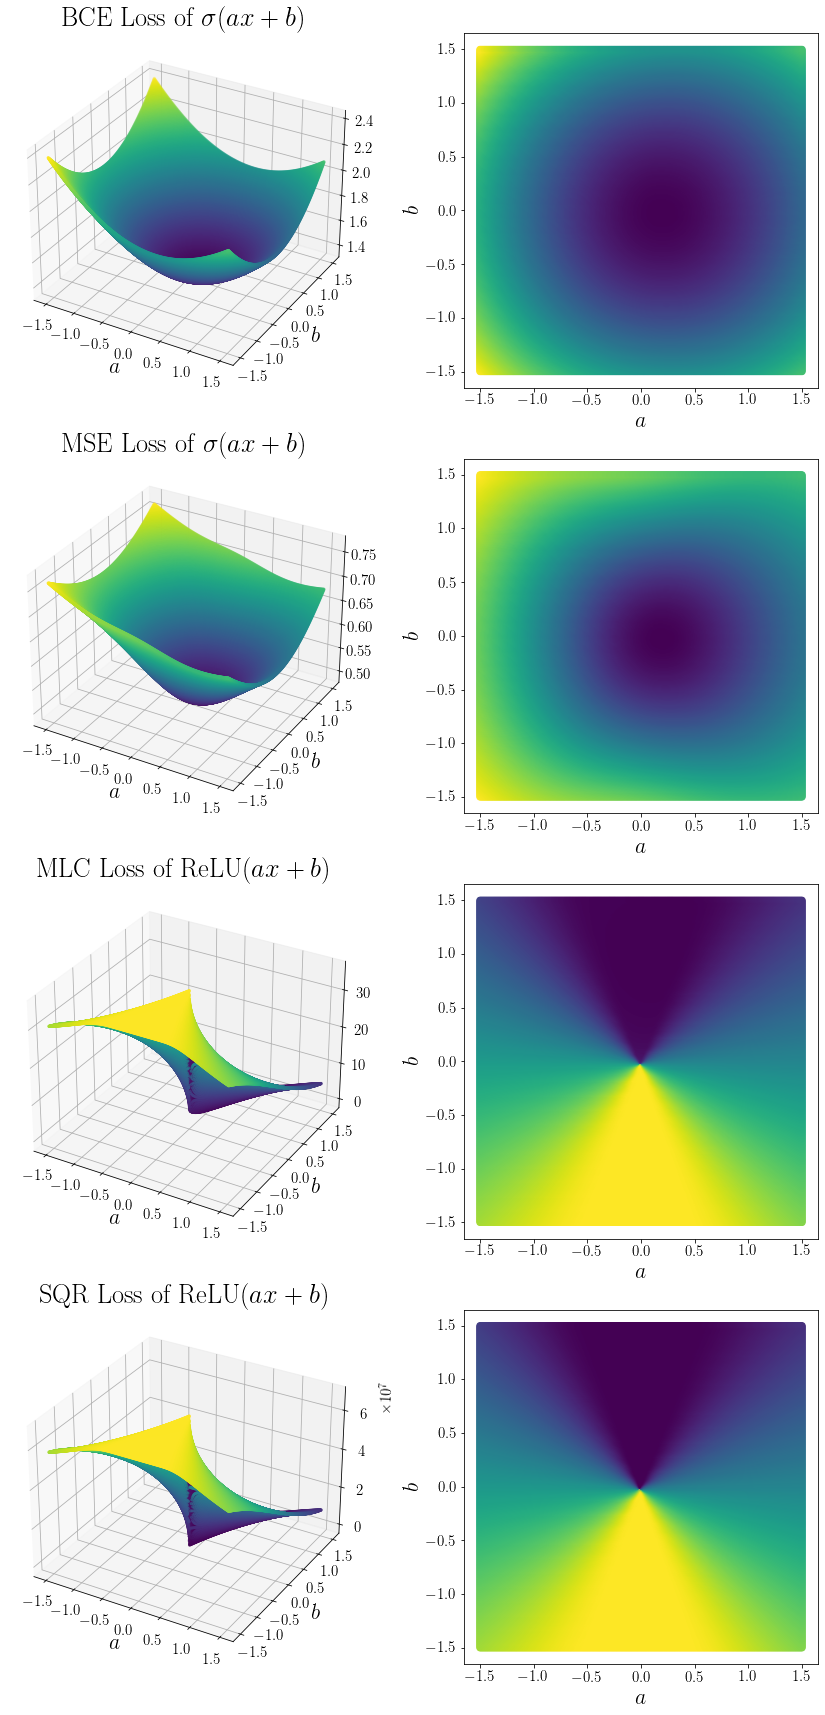

In [19]:
fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'BCE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 3, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MSE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 4)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 5, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MLC Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 6)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 7, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'SQR Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 8)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

In [21]:
nbce_zs = np.load('anims/nbce_zs.npy')
nmse_zs = np.load('anims/nmse_zs.npy')
nmlc_zs = np.load('anims/nmlc_zs.npy')
nsqr_zs = np.load('anims/nsqr_zs.npy')

In [27]:
x_min = g[nbce_zs == min(nbce_zs)][:, 0]
y_min = g[nbce_zs == min(nbce_zs)][:, 1]
z_min = nbce_zs[nbce_zs == min(nbce_zs)]

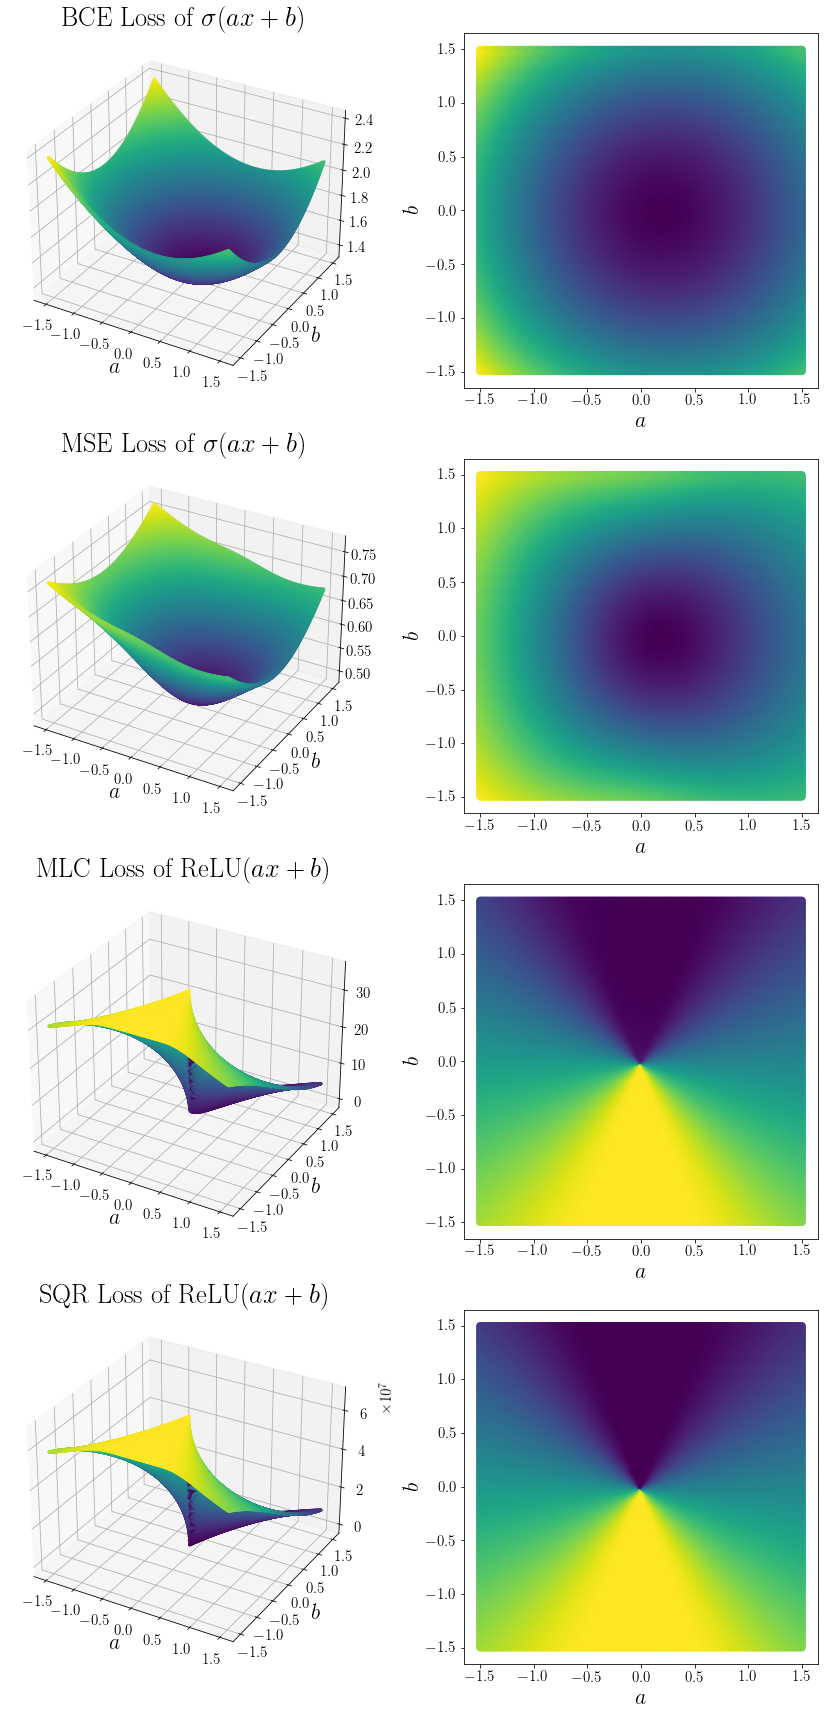

In [23]:
fig = plt.figure(figsize = (15, 30))
ax = fig.add_subplot(4, 2, 1, projection = '3d')
ax.scatter(xs, ys, nbce_zs, s = 5, c = nbce_zs, cmap = 'viridis')
ax.scatter(
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'BCE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 2)
ax.scatter(xs, ys, c = nbce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 3, projection = '3d')
ax.scatter(xs, ys, nmse_zs, s = 5, c = nmse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MSE Loss of $\sigma(ax + b)$')

ax = fig.add_subplot(4, 2, 4)
ax.scatter(xs, ys, c = nmse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 5, projection = '3d')
ax.scatter(xs, ys, nmlc_zs, s = 5, c = nmlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'MLC Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 6)
ax.scatter(xs, ys, c = nmlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

ax = fig.add_subplot(4, 2, 7, projection = '3d')
ax.scatter(xs, ys, nsqr_zs, s = 5, c = nsqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_title(r'SQR Loss of ${\rm ReLU}(ax + b)$')

ax = fig.add_subplot(4, 2, 8)
ax.scatter(xs, ys, c = nsqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

# Rotating Plots

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'BCE Loss of $\sigma(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=False)  
ani.save('anims/bce_2.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'MSE Loss of $\sigma(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/mse.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'MLC Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/mlc.gif')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'SQR Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/sqr.gif')

# Static Plots

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'BCE Loss of $\sigma(ax + b)$')

#plt.savefig('plots/scratch/bce_landscape_100.png',
#            dpi=1200, 
#            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = bce_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'BCE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/bce_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'MSE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/mse_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = mse_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'MSE Loss of $\sigma(ax + b)$')

plt.savefig('plots/scratch/mse_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, mlc_zs, c = mlc_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'MLC Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/mlc_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = mlc_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'MLC Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/mlc_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(xs, ys, sqr_zs, c = sqr_zs, cmap = 'viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.title(r'SQR Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/sqr_landscape_100.png',
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(xs, ys, c = sqr_zs, cmap='viridis')
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.gca().set_aspect('equal')
plt.title(r'SQR Loss of ReLU$(ax + b)$')

plt.savefig('plots/scratch/sqr_landscape_100_flat.png',
            dpi=1200, 
            bbox_inches='tight')

# Shifting Gaussians

## BCE

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [bce(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 10)
    plt.savefig('anims/shift/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    i += 1

## MSE

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [mse(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0.2, 1)
    plt.savefig('anims/shift/mse/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## MLC

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [mlc(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 38)
    plt.savefig('anims/shift/mlc/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## SQR

In [ ]:
ms = np.arange(0.1, 1.01, 0.01)
N = 5 * 10**4

i = 0
for m in ms:
    bkgd = stats.norm.rvs(-m, 1, size = N)
    sgnl = stats.norm.rvs(+m, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for p in g:
        zs += [sqr(p[0], p[1])]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0, 70000000)
    plt.savefig('anims/shift/sqr/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

# $A/B$ Parametrizations

## MSE

In [ ]:
ps = np.arange(-2, 2, 0.05)
N = 5 * 10**4

i = 0
for p in ps:
    bkgd = stats.norm.rvs(-1, 1, size = N)
    sgnl = stats.norm.rvs(+1, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for pt in g:
        zs += [mse_p(pt[0], pt[1], p)]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_zlim(0.2, 5)
    plt.savefig('anims/mse_ab/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

## SQR

In [ ]:
rs = np.arange(-2, 2, 0.05)
N = 5 * 10**4

i = 0
for r in rs:
    bkgd = stats.norm.rvs(-1, 1, size = N)
    sgnl = stats.norm.rvs(+1, 1, size = N)
    X = np.concatenate((bkgd, sgnl))
    y = np.concatenate((np.zeros(N), np.ones(N)))

    xs = g[:, 0]
    ys = g[:, 1]
    zs = []
    for pt in g:
        zs += [sqr_r(pt[0], pt[1], r)]

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(xs, ys, zs, s = 5, c = zs, cmap = 'viridis')
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set_zlim(0, 70000000)
    plt.savefig('anims/sqr_ab/{}.png'.format(i),
                dpi=1200, 
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)
    i += 1

# $C$ Parametrizations

## MLC

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, exp_mlc_zs, s = 5, c = exp_mlc_zs, cmap = 'viridis')
    ax.set_zlim(0, 10)
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'Exp MLC Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/exp_mlc_2.gif')

## SQR

In [ ]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')

def init():
    ax.scatter(xs, ys, exp_sqr_zs, s = 5, c = exp_sqr_zs, cmap = 'viridis')
    ax.set_zlim(1.5, 6)
    plt.xlabel(r'$a$')
    plt.ylabel(r'$b$')
    plt.title(r'Exp SQR Loss of ReLU$(ax + b)$')
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)  
ani.save('anims/exp_sqr_2.gif')

# Gamma Landscapes

In [ ]:
N = 5 * 10**3
bkgd = stats.gamma.rvs(5, 1, size = N)
sgnl = stats.gamma.rvs(6, 1, size = N)
X = np.concatenate((bkgd, sgnl))
y = np.concatenate((np.zeros(N), np.ones(N)))

In [ ]:
%%time

xs = g[:, 0]
ys = g[:, 1]
bce_zs = []
mse_zs = []
mlc_zs = []
sqr_zs = []
i = 0
for p in g:
    bce_zs += [bce(p[0], p[1])]
    mse_zs += [mse(p[0], p[1])]
    mlc_zs += [mlc(p[0], p[1])]
    sqr_zs += [sqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', bce_zs[-1], mse_zs[-1], mlc_zs[-1], sqr_zs[-1]) 
    i += 1

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'BCE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/bce_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MSE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/mse_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MLC Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/mlc_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'SQR Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/sqr_gammas.png', 
            dpi=1200, 
            bbox_inches='tight')

# Betas

In [ ]:
N = 5 * 10**3
bkgd = stats.beta.rvs(2, 3, size = N)
sgnl = stats.beta.rvs(3, 2, size = N)
X = np.concatenate((bkgd, sgnl))
y = np.concatenate((np.zeros(N), np.ones(N)))

g = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
g = np.append(g[0].reshape(-1,1),g[1].reshape(-1,1),axis = 1)

In [ ]:
%%time

xs = g[:, 0]
ys = g[:, 1]
bce_zs = []
mse_zs = []
mlc_zs = []
sqr_zs = []
i = 0
for p in g:
    bce_zs += [bce(p[0], p[1])]
    mse_zs += [mse(p[0], p[1])]
    mlc_zs += [mlc(p[0], p[1])]
    sqr_zs += [sqr(p[0], p[1])]
    if i % 100 == 0:
        print(i, ':', bce_zs[-1], mse_zs[-1], mlc_zs[-1], sqr_zs[-1]) 
    i += 1

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, bce_zs, s = 5, c = bce_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = bce_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'BCE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/bce_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mse_zs, s = 5, c = mse_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mse_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MSE Loss of $\sigma(ax + b)$', y = 0.92)
plt.savefig('plots/mse_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, mlc_zs, s = 5, c = mlc_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = mlc_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'MLC Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/mlc_betas.png', 
            dpi=1200, 
            bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize = (16, 15))
ax = fig.add_subplot(2, 2, 1, projection = '3d')
ax.scatter(xs, ys, sqr_zs, s = 5, c = sqr_zs, cmap = 'viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')


ax = fig.add_subplot(2, 2, 2)
ax.scatter(xs, ys, c = sqr_zs, cmap='viridis')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')
ax.set_aspect('equal')

fig.suptitle(r'SQR Loss of ReLU$(ax + b)$', y = 0.92)
plt.savefig('plots/sqr_betas.png', 
            dpi=1200, 
            bbox_inches='tight')